In [29]:
import pandas as pd
import json
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix
import joblib

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.dummy import DummyRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from collections import Counter
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv(r"C:\Users\1\Documents\python\work\db.csv")

In [3]:
# функция для вывода всей нужной информации о датафрейме
def data_info(dataframe):
    print(dataframe.info())
    display(dataframe.head())
    display(dataframe.tail())
    display(dataframe.describe())
    print('Пропусков в датафрейме: ', dataframe.isnull().sum())
    print()
    print('Количество явных дубликатов в датафрейме:', dataframe.duplicated().sum())

In [4]:
data_info(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 986 entries, 0 to 985
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             986 non-null    int64  
 1   created_at     986 non-null    object 
 2   call_type      986 non-null    object 
 3   transcription  986 non-null    object 
 4   round          986 non-null    float64
 5   call_duration  986 non-null    int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 46.3+ KB
None


,id,created_at,call_type,transcription,round,call_duration
0,1,2025-09-16 21:00:01.579,REGULAR,"[{""text"": ""Алло. Доброго дня, магазин ДФС, отд...",6.67,187
1,2,2025-09-16 21:00:01.579,REGULAR,"[{""text"": ""Добрый день. Мы это магазин гос. от...",7.33,158
2,3,2025-09-16 21:00:01.579,REGULAR,"[{""text"": ""Магазин ДФС. Дело доставки. По ваше...",5.67,73
3,4,2025-09-16 21:00:01.579,REGULAR,"[{""text"": ""Спасибо. Добрый день, магазин ДФС, ...",4.00,45
4,5,2025-09-16 21:00:01.579,REGULAR,"[{""text"": ""Алло, продолжаю дозвониться."", ""end...",1.00,29


,id,created_at,call_type,transcription,round,call_duration
981,1005,2025-09-23 23:00:04.728,AUDIO_BADGE,"[{""text"": ""23 сентября, 9.53, Куров Данила. 23...",2.25,7200
982,1006,2025-09-23 23:00:04.728,AUDIO_BADGE,"[{""text"": ""Редактор субтитров А.Семкин Коррект...",5.63,7200
983,1007,2025-09-23 23:00:04.728,AUDIO_BADGE,"[{""text"": ""Девушка или мужчина успеет прыгать?...",4.88,7200
984,1008,2025-09-23 23:00:04.728,AUDIO_BADGE,"[{""text"": ""Я согласен. То есть, врачи часто ре...",6.50,7200
985,1009,2025-09-23 23:00:04.728,AUDIO_BADGE,"[{""text"": ""А, выгодная позиция. Ну нет, ну как...",5.13,744


,id,round,call_duration
count,986.000000,986.000000,986.000000
mean,499.430020,4.653377,5185.949290
std,290.069961,2.104237,7515.356533
min,1.000000,0.000000,6.000000
25%,249.250000,3.380000,68.000000
50%,498.000000,4.880000,578.000000
75%,747.750000,6.000000,7200.000000
max,1009.000000,9.330000,32751.000000


Пропусков в датафрейме:  id               0
created_at       0
call_type        0
transcription    0
round            0
call_duration    0
dtype: int64

Количество явных дубликатов в датафрейме: 0


### Извлечем текст из json формата транскрипции

In [5]:
# Создаем копию исходных данных для безопасной работы
df_clean = df.copy()

In [6]:
def extract_text_from_transcription(transcription):
    """Извлекает текст из JSON формата транскрипции"""
    try:
        if pd.isna(transcription) or transcription == "":
            return ""
        
        # Если это строковое представление JSON
        if isinstance(transcription, str):
            # Пробуем распарсить JSON
            try:
                data = json.loads(transcription)
                if isinstance(data, list):
                    # Объединяем все текстовые сегменты
                    full_text = " ".join([segment.get('text', '') for segment in data if 'text' in segment])
                    return full_text
                else:
                    return str(data)
            except json.JSONDecodeError:
                # Если не JSON, возвращаем как есть
                return transcription
        else:
            return str(transcription)
    except Exception as e:
        print(f"Ошибка при обработке транскрипции: {e}")
        return ""

# Применяем функцию извлечения текста к clean датасету
df_clean['full_text'] = df_clean['transcription'].apply(extract_text_from_transcription)

In [7]:
# Проверяем результат
print("Извлечение текста завершено:")
print(f"Успешно извлечено: {df_clean['full_text'].notna().sum()} текстов")
print(f"Средняя длина: {df_clean['full_text'].str.len().mean():.0f} символов")
print(f"Минимальная длина: {df_clean['full_text'].str.len().min()} символов")
print(f"Максимальная длина: {df_clean['full_text'].str.len().max()} символов")

# Проверяем несколько примеров
print("\nПримеры извлеченных текстов:")
for i in range(min(3, len(df_clean))):
    text = df_clean['full_text'].iloc[i]
    print(f"Запись {i+1}: {text[:100]}..." if len(text) > 100 else f"Запись {i+1}: {text}")

Извлечение текста завершено:
Успешно извлечено: 986 текстов
Средняя длина: 19759 символов
Минимальная длина: 5 символов
Максимальная длина: 208408 символов

Примеры извлеченных текстов:
Запись 1: Алло. Доброго дня, магазин ДФС, отдел наставки. Был пропущен звоночек от вас. Да, здрасте. Я хотела ...
Запись 2: Добрый день. Мы это магазин гос. отдела доставки. По вашему заказу небольшое уточнение хотели бы сде...
Запись 3: Магазин ДФС. Дело доставки. По вашему заказу небольшое уточнение хотели бы сделать. Видим, что спосо...


### Проведем анализ распределения оценок


РАСПРЕДЕЛЕНИЕ В df_clean:
Всего записей: 986
REGULAR: 491
AUDIO_BADGE: 495


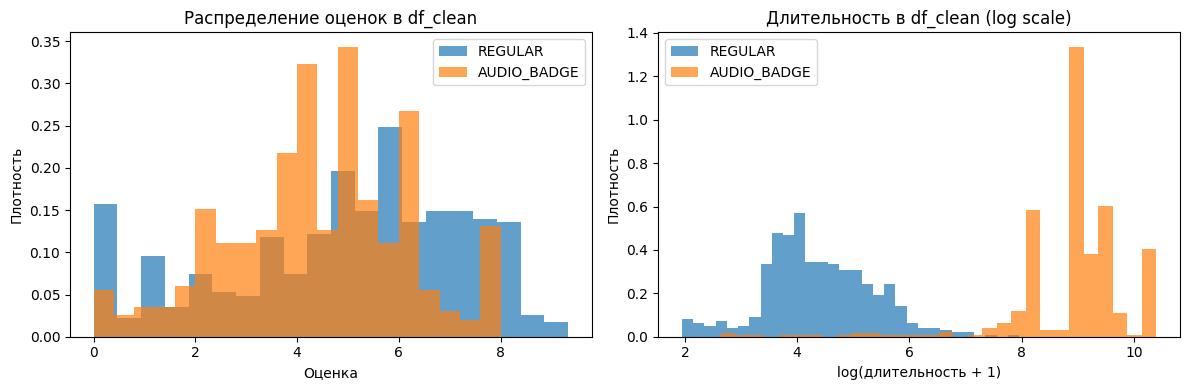

In [8]:
# Разделяем по типам в clean датасете
df_clean_regular = df_clean[df_clean['call_type'] == 'REGULAR'].copy()
df_clean_audio = df_clean[df_clean['call_type'] == 'AUDIO_BADGE'].copy()

print(f"\nРАСПРЕДЕЛЕНИЕ В df_clean:")
print(f"Всего записей: {len(df_clean)}")
print(f"REGULAR: {len(df_clean_regular)}")
print(f"AUDIO_BADGE: {len(df_clean_audio)}")

# Визуализация распределения оценок
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(df_clean_regular['round'], bins=20, alpha=0.7, label='REGULAR', density=True)
plt.hist(df_clean_audio['round'], bins=20, alpha=0.7, label='AUDIO_BADGE', density=True)
plt.title('Распределение оценок в df_clean')
plt.xlabel('Оценка')
plt.ylabel('Плотность')
plt.legend()

plt.subplot(1, 2, 2)
# Длительность в логарифмической шкале для наглядности
plt.hist(np.log1p(df_clean_regular['call_duration']), bins=30, alpha=0.7, label='REGULAR', density=True)
plt.hist(np.log1p(df_clean_audio['call_duration']), bins=30, alpha=0.7, label='AUDIO_BADGE', density=True)
plt.title('Длительность в df_clean (log scale)')
plt.xlabel('log(длительность + 1)')
plt.ylabel('Плотность')
plt.legend()

plt.tight_layout()
plt.show()

In [9]:
# Анализируем содержание текстов в clean датасете
print("АНАЛИЗ СОДЕРЖАНИЯ ТЕКСТОВ В df_clean:")
print("="*50)

# Функция для быстрого анализа содержания
def quick_content_analysis(text):
    """Быстрый анализ содержания текста"""
    if not text or pd.isna(text):
        return "empty", 0
    
    text_lower = text.lower()
    word_count = len(text.split())
    
    # Простые маркеры
    if any(word in text_lower for word in ['алло', 'добр', 'здравствуйте', 'магазин']):
        return "likely_call", word_count
    elif any(word in text_lower for word in ['субтитр', 'редактор', 'таймкод']):
        return "technical", word_count
    elif word_count < 10:
        return "short", word_count
    else:
        return "other", word_count

# Применяем к clean датасету
content_analysis = df_clean['full_text'].apply(lambda x: quick_content_analysis(x)[0])
df_clean['content_type'] = content_analysis

print("Распределение типов контента:")
print(df_clean['content_type'].value_counts())

print("\nРаспределение по типам звонков:")
content_by_type = pd.crosstab(df_clean['call_type'], df_clean['content_type'])
print(content_by_type)

АНАЛИЗ СОДЕРЖАНИЯ ТЕКСТОВ В df_clean:
Распределение типов контента:
content_type
likely_call    933
short           31
other           18
technical        4
Name: count, dtype: int64

Распределение по типам звонков:
content_type  likely_call  other  short  technical
call_type                                         
AUDIO_BADGE           480      5      6          4
REGULAR               453     13     25          0


### Промежуточный вывод

Распределение оценок:* плотность оценок больше у regular от 4 до 9
- плотность распределения оценок audio_badge от 2 до 6

Что касается длительности: подтвердили условие, по условию audio_badge это запись "всего дня", поэтому на лог шкале они находятся больше 7, а regular до 7

По распределению типов контента значительно преобладает "обычный звонок".

## Feature Engineering

In [10]:
# создадим базовые признаки из текста и метаданных
def create_basic_features(df):
    """Создает базовые признаки из текста и метаданных"""
    
    features_df = df[['id', 'call_type', 'round', 'call_duration']].copy()
    
    # Базовые метрики текста
    features_df['text_length'] = df['full_text'].str.len().fillna(0)
    features_df['word_count'] = df['full_text'].str.split().str.len().fillna(0)
    features_df['sentence_count'] = df['full_text'].str.count(r'[.!?]+').fillna(0)
    
    # Плотность текста (слов в секунду)
    features_df['words_per_second'] = features_df['word_count'] / features_df['call_duration'].clip(lower=1)
    features_df['chars_per_second'] = features_df['text_length'] / features_df['call_duration'].clip(lower=1)
    
    # Средняя длина слова
    features_df['avg_word_length'] = features_df['text_length'] / features_df['word_count'].replace(0, 1)
    
    return features_df

# Создаем базовые признаки
basic_features = create_basic_features(df_clean)
print("Базовые признаки созданы:")
print(basic_features.describe())

Базовые признаки созданы:
                id       round  call_duration    text_length    word_count  \
count   986.000000  986.000000     986.000000     986.000000    986.000000   
mean    499.430020    4.653377    5185.949290   19758.957404   3272.992901   
std     290.069961    2.104237    7515.356533   29976.663234   4986.217328   
min       1.000000    0.000000       6.000000       5.000000      1.000000   
25%     249.250000    3.380000      68.000000     645.500000     99.250000   
50%     498.000000    4.880000     578.000000    4058.500000    638.500000   
75%     747.750000    6.000000    7200.000000   32847.000000   5437.500000   
max    1009.000000    9.330000   32751.000000  208408.000000  34901.000000   

       sentence_count  words_per_second  chars_per_second  avg_word_length  
count      986.000000        986.000000        986.000000       986.000000  
mean       606.005071          1.032152          6.417279         6.271862  
std        891.365041          0.648484 

In [11]:
# введем также лингвистические признаки
def create_linguistic_features(df):
    """Создает лингвистические признаки"""
    
    features = {}
    
    # Паузы и колебания (русские)
    pause_patterns = ['эээ', 'ммм', 'ну', 'как бы', 'типа', 'в общем', 'это самое']
    
    # Эмоциональные маркеры
    positive_words = ['спасибо', 'благодарю', 'отлично', 'хорошо', 'понятно', 'удобно', 'прекрасно', 'замечательно']
    negative_words = ['проблема', 'дорого', 'неудобно', 'сложно', 'подождите', 'не знаю', 'извините', 'сожалею']
    question_words = ['почему', 'как', 'что', 'когда', 'где', 'сколько', 'зачем']
    
    for idx, row in df.iterrows():
        text = row['full_text'] or ""
        text_lower = text.lower()
        
        # Паузы
        features[idx] = {
            'pause_count': sum(text_lower.count(pattern) for pattern in pause_patterns),
            'positive_words': sum(text_lower.count(word) for word in positive_words),
            'negative_words': sum(text_lower.count(word) for word in negative_words),
            'question_words': sum(text_lower.count(word) for word in question_words),
        }
        
        # Отношения (нормализованные по количеству слов)
        word_count = len(text.split()) or 1
        features[idx]['pause_density'] = features[idx]['pause_count'] / word_count
        features[idx]['positive_ratio'] = features[idx]['positive_words'] / word_count
        features[idx]['negative_ratio'] = features[idx]['negative_words'] / word_count
        features[idx]['question_ratio'] = features[idx]['question_words'] / word_count
        
        # Эмоциональный баланс
        total_emotional = features[idx]['positive_words'] + features[idx]['negative_words']
        if total_emotional > 0:
            features[idx]['emotional_balance'] = (
                features[idx]['positive_words'] - features[idx]['negative_words']
            ) / total_emotional
        else:
            features[idx]['emotional_balance'] = 0
    
    return pd.DataFrame.from_dict(features, orient='index')

# Создаем лингвистические признаки
linguistic_features = create_linguistic_features(df_clean)
print("Лингвистические признаки созданы:")
print(linguistic_features.describe())

Лингвистические признаки созданы:
       pause_count  positive_words  negative_words  question_words  \
count   986.000000      986.000000      986.000000      986.000000   
mean     88.853955       22.529412        7.691684      128.625761   
std     135.709914       31.150358       12.344804      200.916330   
min       0.000000        0.000000        0.000000        0.000000   
25%       2.000000        2.250000        0.000000        2.000000   
50%      16.000000        7.000000        1.000000       22.500000   
75%     141.000000       36.000000       11.000000      205.750000   
max     924.000000      232.000000       79.000000     1471.000000   

       pause_density  positive_ratio  negative_ratio  question_ratio  \
count     986.000000      986.000000      986.000000      986.000000   
mean        0.021866        0.017255        0.001847        0.030369   
std         0.014313        0.037015        0.003111        0.016344   
min         0.000000        0.000000        0.0

In [12]:
# также попробуем создать признаки, специфичные для типов звонков

def create_call_type_features(df):
    """Создает признаки специфичные для типов звонков"""
    
    features = {}
    
    # Ключевые слова для разных сценариев
    business_keywords = ['цена', 'стоимость', 'доставка', 'заказ', 'оплата', 'наличие', 'скидка']
    greeting_patterns = ['добрый', 'здравствуйте', 'добро пожаловать', 'магазин']
    closing_patterns = ['до свидания', 'всего доброго', 'хорошего дня', 'спасибо за звонок']
    
    for idx, row in df.iterrows():
        text = row['full_text'] or ""
        text_lower = text.lower()
        word_count = len(text.split()) or 1
        
        features[idx] = {
            # Бизнес-ключевые слова
            'business_words': sum(text_lower.count(word) for word in business_keywords),
            'greeting_count': sum(text_lower.count(pattern) for pattern in greeting_patterns),
            'closing_count': sum(text_lower.count(pattern) for pattern in closing_patterns),
            
            # Структурные признаки
            'has_greeting': int(any(pattern in text_lower for pattern in greeting_patterns)),
            'has_closing': int(any(pattern in text_lower for pattern in closing_patterns)),
            
            # Для AUDIO_BADGE: признаки "шума"
            'is_audio_badge': 1 if row['call_type'] == 'AUDIO_BADGE' else 0,
            'is_regular': 1 if row['call_type'] == 'REGULAR' else 0,
        }
        
        # Нормализованные версии
        features[idx]['business_density'] = features[idx]['business_words'] / word_count
        features[idx]['greeting_density'] = features[idx]['greeting_count'] / word_count
        features[idx]['closing_density'] = features[idx]['closing_count'] / word_count
    
    return pd.DataFrame.from_dict(features, orient='index')

# Создаем специфичные признаки
call_type_features = create_call_type_features(df_clean)
print("Call-type специфичные признаки созданы:")
print(call_type_features.describe())

Call-type специфичные признаки созданы:
       business_words  greeting_count  closing_count  has_greeting  \
count      986.000000      986.000000     986.000000    986.000000   
mean         5.014199       15.116633      10.579108      0.920892   
std          7.334073       21.411311      16.688253      0.270043   
min          0.000000        0.000000       0.000000      0.000000   
25%          0.000000        2.000000       1.000000      1.000000   
50%          2.000000        4.000000       3.000000      1.000000   
75%          7.000000       21.000000      14.000000      1.000000   
max         66.000000      152.000000     137.000000      1.000000   

       has_closing  is_audio_badge  is_regular  business_density  \
count   986.000000      986.000000  986.000000        986.000000   
mean      0.820487        0.502028    0.497972          0.005545   
std       0.383976        0.500250    0.500250          0.010414   
min       0.000000        0.000000    0.000000          0

ФИНАЛЬНЫЙ НАБОР ПРИЗНАКОВ:
Размер: (986, 29)
Колонки: ['id', 'call_type', 'round', 'call_duration', 'text_length', 'word_count', 'sentence_count', 'words_per_second', 'chars_per_second', 'avg_word_length', 'pause_count', 'positive_words', 'negative_words', 'question_words', 'pause_density', 'positive_ratio', 'negative_ratio', 'question_ratio', 'emotional_balance', 'business_words', 'greeting_count', 'closing_count', 'has_greeting', 'has_closing', 'is_audio_badge', 'is_regular', 'business_density', 'greeting_density', 'closing_density']

ТОП-15 признаков по корреляции с оценкой:
round                1.000000
has_greeting         0.442323
emotional_balance    0.406796
words_per_second     0.400246
chars_per_second     0.397809
has_closing          0.363241
avg_word_length      0.242712
greeting_density     0.222142
business_density     0.206960
question_ratio       0.166533
pause_density        0.156265
is_regular           0.129258
is_audio_badge       0.129258
negative_words       0.11

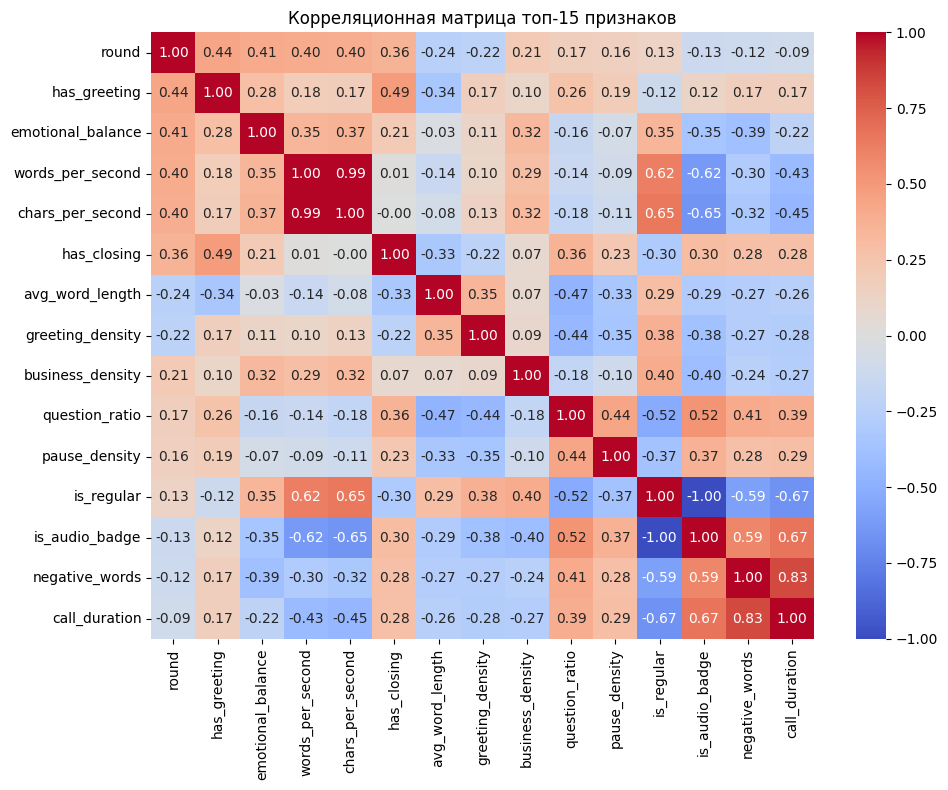

In [13]:
# объединим все признаки
# Объединяем все признаки
final_features = pd.concat([
    basic_features,
    linguistic_features,
    call_type_features
], axis=1)

print("ФИНАЛЬНЫЙ НАБОР ПРИЗНАКОВ:")
print(f"Размер: {final_features.shape}")
print(f"Колонки: {list(final_features.columns)}")

# Проверяем корреляцию с целевой переменной
correlation_with_target = final_features.select_dtypes(include=[np.number]).corr()['round'].abs().sort_values(ascending=False)

print("\nТОП-15 признаков по корреляции с оценкой:")
print(correlation_with_target.head(15))

# Визуализация корреляций
plt.figure(figsize=(10, 8))
top_features = correlation_with_target.head(15).index
corr_matrix = final_features[top_features].corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Корреляционная матрица топ-15 признаков')
plt.tight_layout()
plt.show()

СРАВНЕНИЕ ПРИЗНАКОВ ПО ТИПАМ ЗВОНКОВ:
                   REGULAR_mean  AUDIO_BADGE_mean  Difference
words_per_second       1.434153          0.633400    0.800754
emotional_balance      0.733494          0.454824    0.278670
has_closing            0.704684          0.935354   -0.230669
has_greeting           0.887984          0.953535   -0.065552
positive_ratio         0.025053          0.009519    0.015534
pause_density          0.016535          0.027153   -0.010618
business_density       0.009769          0.001355    0.008414
negative_ratio         0.001316          0.002374   -0.001058


<Figure size 1200x600 with 0 Axes>

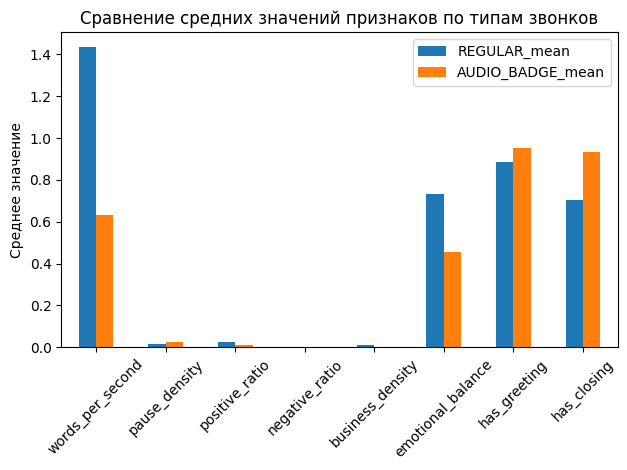

In [14]:
# Анализируем различия в признаках между типами звонков
print("СРАВНЕНИЕ ПРИЗНАКОВ ПО ТИПАМ ЗВОНКОВ:")
print("="*50)

# Разделяем по типам
regular_features = final_features[final_features['call_type'] == 'REGULAR']
audio_features = final_features[final_features['call_type'] == 'AUDIO_BADGE']

# Сравниваем средние значения ключевых признаков
key_features = ['words_per_second', 'pause_density', 'positive_ratio', 'negative_ratio', 
               'business_density', 'emotional_balance', 'has_greeting', 'has_closing']

comparison_df = pd.DataFrame({
    'REGULAR_mean': regular_features[key_features].mean(),
    'AUDIO_BADGE_mean': audio_features[key_features].mean(),
    'Difference': regular_features[key_features].mean() - audio_features[key_features].mean()
})

print(comparison_df.sort_values('Difference', key=abs, ascending=False))

# Визуализация различий
plt.figure(figsize=(12, 6))
comparison_df[['REGULAR_mean', 'AUDIO_BADGE_mean']].plot(kind='bar')
plt.title('Сравнение средних значений признаков по типам звонков')
plt.ylabel('Среднее значение')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## Промежуточный вывод по Feature Engineering

### ТОП-5 самых важных признаков для предсказания оценки:

**1. has_greeting (корр. 0.44)**
Высокая корреляция! Наличие приветствия сильно связано с высокой оценкой
Интерпретация: Звонки, где менеджер вежливо приветствует клиента, получают более высокие оценки

**2. emotional_balance (корр. 0.41)**
Баланс эмоций = (положительные - отрицательные) / (положительные + отрицательные)
Интерпретация: Преобладание позитивных слов над негативными ведет к более высоким оценкам

**3. words_per_second (корр. 0.40)**
Темп речи - слова в секунду
Интерпретация: Более высокая плотность речи связана с лучшими оценками (возможно, показатель уверенности/компетентности)

**4. chars_per_second (корр. 0.40)**
Интенсивность общения - символы в секунду
Интерпретация: Аналогично темпу речи - активное общение связано с лучшим качеством

**5. has_closing (корр. 0.36)**
Наличие прощания
Интерпретация: Вежливое завершение звонка важно для клиентского опыта

### Ключевые инсайты:

**Что работает хорошо:**
- Вежливость (приветствие/прощание) - самый сильный предиктор
- Позитивный настрой - эмоциональный баланс критически важен  
- Активность - темп речи показывает вовлеченность

**Что требует осторожности:**
- negative_words сильно коррелирует с call_duration (0.83)
- Возможно, в длинных звонках просто больше слов вообще
- Нужно использовать нормализованные версии (negative_ratio)

**Неожиданные находки:**
- avg_word_length (0.24) - более длинные слова связаны с лучшими оценками
- Возможно, показатель более формального/профессионального общения

### Сравнение по типам звонков:

**Критические отличия между REGULAR и AUDIO_BADGE:**

**1. words_per_second (разница: 0.80)**
- REGULAR: 1.43 слов/сек
- AUDIO_BADGE: 0.63 слов/сек
- В 2.3 раза выше плотность речи в REGULAR!
- Интерпретация: В рабочих записях много пауз, молчания, фонового шума

**2. emotional_balance (разница: 0.28)**
- REGULAR: 0.73 (сильно позитивный)
- AUDIO_BADGE: 0.45 (умеренно позитивный)
- REGULAR звонки значительно более позитивны
- Интерпретация: В рабочих записях смешаны разные типы взаимодействий

**3. has_closing (разница: -0.23)**
- REGULAR: 0.70
- AUDIO_BADGE: 0.94
- В AUDIO_BADGE чаще есть прощания
- Возможное объяснение: В длинных записях больше различных взаимодействий, включая завершенные

**Умеренные отличия:**
**4. positive_ratio (разница: 0.016)**
- REGULAR звонки содержат больше позитивных слов

**5. business_density (разница: 0.008)**
- REGULAR звонки более деловые/структурированные

### Итоговые выводы для модели:

**Подтвержденные гипотезы:**
- REGULAR звонки - структурированные, плотные, позитивные, деловые
- AUDIO_BADGE - разреженные, смешанные эмоции, разнообразные сценарииDGE - разреженные, смешанные эмоции, разнообразные сценарии более формального/профессионального общения

## Переходим к обучению моделей

In [18]:

# Упрощенная функция предобработки (без pymorphy2 для избежания ошибок)
def simple_preprocess_text(text):
    """Упрощенная предобработка текста"""
    if not text or pd.isna(text):
        return ""
    
    # Базовая очистка
    text = re.sub(r'[^\w\s]', ' ', text)  # удаляем спецсимволы
    text = re.sub(r'\d+', '', text)       # удаляем цифры
    text = text.lower()                   # к нижнему регистру
    text = re.sub(r'\s+', ' ', text)      # удаляем множественные пробелы
    
    # Базовые русские стоп-слова
    russian_stopwords = {
        'и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она',
        'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее',
        'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда',
        'даже', 'ну', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас',
        'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может',
        'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была',
        'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда',
        'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом',
        'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех',
        'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше',
        'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три',
        'эту', 'моя', 'впрочем', 'хорошо', 'свою', 'этой', 'перед', 'иногда', 'лучше', 'чуть',
        'том', 'нельзя', 'такой', 'им', 'более', 'всегда', 'конечно', 'всю', 'между', 'это', 'ну'
    }
    
    # Удаляем стоп-слова
    words = [word for word in text.split() if word not in russian_stopwords and len(word) > 2]
    
    return ' '.join(words)

# Применяем упрощенную предобработку
print("Начинаем упрощенную предобработку текста...")
df_clean['processed_text'] = df_clean['full_text'].apply(simple_preprocess_text)

# Проверяем результат
print("Предобработка завершена")
print(f"Пример обработанного текста: {df_clean['processed_text'].iloc[0][:100]}...")
print(f"Средняя длина после обработки: {df_clean['processed_text'].str.len().mean():.0f} символов")

Начинаем упрощенную предобработку текста...
Предобработка завершена
Пример обработанного текста: алло доброго дня магазин дфс отдел наставки пропущен звоночек здрасте хотела уточнить подскажите поч...
Средняя длина после обработки: 12092 символов


In [20]:
# создадим TF-IDF матрицу
# Создаем TF-IDF векторайзер с безопасными параметрами
tfidf_vectorizer = TfidfVectorizer(
    max_features=500,           # Уменьшим количество признаков для стабильности
    min_df=2,                   
    max_df=0.85,                
    ngram_range=(1, 1),         # Начнем с униграмм для стабильности
    stop_words='english'        # Используем встроенные стоп-слова (английские не помешают)
)

print("Создаем TF-IDF матрицу...")
tfidf_matrix = tfidf_vectorizer.fit_transform(df_clean['processed_text'])

print(f"TF-IDF матрица создана: {tfidf_matrix.shape}")
print(f"Количество фич TF-IDF: {len(tfidf_vectorizer.get_feature_names_out())}")

# Покажем топ-15 самых важных слов по TF-IDF
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_scores = tfidf_matrix.mean(axis=0).A1
top_words_idx = tfidf_scores.argsort()[-15:][::-1]

print("Топ-15 слов по TF-IDF:")
for idx in top_words_idx:
    print(f"{feature_names[idx]}: {tfidf_scores[idx]:.4f}")

Создаем TF-IDF матрицу...
TF-IDF матрица создана: (986, 500)
Количество фич TF-IDF: 500
Топ-15 слов по TF-IDF:
просто: 0.1413
спасибо: 0.1093
добрый: 0.1072
день: 0.0995
вообще: 0.0941
доброго: 0.0740
магазин: 0.0596
очень: 0.0580
свидания: 0.0554
дня: 0.0552
получается: 0.0546
пожалуйста: 0.0535
давайте: 0.0534
знаю: 0.0526
дфс: 0.0520


In [22]:
selected_features = ['has_greeting', 'emotional_balance','words_per_second','has_closing','is_regular']
# Подготовка числовых признаков
print("Подготавливаем числовые признаки...")

# Берем наш выбранный набор признаков
X_numeric = final_features[selected_features].copy()

# Проверяем и обрабатываем пропуски
print(f"Пропуски в числовых признаках: {X_numeric.isnull().sum().sum()}")
X_numeric = X_numeric.fillna(0)

print(f"Числовые признаки: {X_numeric.shape}")

# Объединяем TF-IDF и числовые признаки
print("Объединяем TF-IDF и числовые признаки...")

# Преобразуем числовые признаки в sparse matrix
numeric_matrix = csr_matrix(X_numeric.values.astype(float))

# Объединяем
X_combined = hstack([tfidf_matrix, numeric_matrix])

print(f"Объединенная матрица признаков: {X_combined.shape}")
print(f"TF-IDF features: {tfidf_matrix.shape[1]}")
print(f"Numerical features: {X_numeric.shape[1]}")
print(f"Total features: {X_combined.shape[1]}")

Подготавливаем числовые признаки...
Пропуски в числовых признаках: 0
Числовые признаки: (986, 5)
Объединяем TF-IDF и числовые признаки...
Объединенная матрица признаков: (986, 505)
TF-IDF features: 500
Numerical features: 5
Total features: 505


In [23]:
from sklearn.model_selection import train_test_split
# подготовка данных для модели

# Целевая переменная
y = df_clean['round']

# Разделяем на train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, 
    y, 
    test_size=0.2, 
    random_state=42,
    stratify=df_clean['call_type']  # Стратификация по типу звонка
)

print("Разделение данных завершено:")
print(f"Train: {X_train.shape[0]} samples")
print(f"Test: {X_test.shape[0]} samples")
print(f"Train targets: {y_train.mean():.2f} ± {y_train.std():.2f}")
print(f"Test targets: {y_test.mean():.2f} ± {y_test.std():.2f}")

# Проверяем распределение типов звонков
train_indices = y_train.index
test_indices = y_test.index

print(f"\nРаспределение типов в train:")
print(df_clean.loc[train_indices, 'call_type'].value_counts(normalize=True))
print(f"\nРаспределение типов в test:")
print(df_clean.loc[test_indices, 'call_type'].value_counts(normalize=True))

Разделение данных завершено:
Train: 788 samples
Test: 198 samples
Train targets: 4.65 ± 2.10
Test targets: 4.68 ± 2.13

Распределение типов в train:
call_type
AUDIO_BADGE    0.502538
REGULAR        0.497462
Name: proportion, dtype: float64

Распределение типов в test:
call_type
REGULAR        0.5
AUDIO_BADGE    0.5
Name: proportion, dtype: float64


In [24]:
# сохранение подготовленных данных
# Сохраняем подготовленные данные
preprocessing_artifacts = {
    'tfidf_vectorizer': tfidf_vectorizer,
    'selected_features': selected_features,
    'feature_names': feature_names,
    'X_train': X_train,
    'X_test': X_test, 
    'y_train': y_train,
    'y_test': y_test
}

joblib.dump(preprocessing_artifacts, 'preprocessing_artifacts.pkl')
print("Препроцессинг артефакты сохранены в preprocessing_artifacts.pkl")

print("=" * 60)
print("TF-IDF ПРЕПРОЦЕССИНГ ЗАВЕРШЕН")
print("=" * 60)
print(f"Итоговые признаки: {X_combined.shape[1]}")
print(f"  - TF-IDF: {tfidf_matrix.shape[1]} features")
print(f"  - Numerical: {len(selected_features)} features")
print(f"  - Train: {X_train.shape[0]} samples") 
print(f"  - Test: {X_test.shape[0]} samples")

Препроцессинг артефакты сохранены в preprocessing_artifacts.pkl
TF-IDF ПРЕПРОЦЕССИНГ ЗАВЕРШЕН
Итоговые признаки: 505
  - TF-IDF: 500 features
  - Numerical: 5 features
  - Train: 788 samples
  - Test: 198 samples


## Обучение моделей

In [31]:
# Правильное разделение: сначала разделяем индексы, потом создаем матрицы
indices = np.arange(len(df_clean))

# Разделяем индексы на train+val и test
idx_temp, idx_test = train_test_split(
    indices, test_size=0.2, random_state=42, 
    stratify=df_clean['call_type']
)

# Разделяем train+val на train и val
idx_train, idx_val = train_test_split(
    idx_temp, test_size=0.25, random_state=42, 
    stratify=df_clean.loc[idx_temp, 'call_type']
)

# Создаем соответствующие матрицы признаков
X_train = X_combined[idx_train]
X_val = X_combined[idx_val] 
X_test = X_combined[idx_test]

# Соответствующие целевые переменные
y_train = y.iloc[idx_train]
y_val = y.iloc[idx_val]
y_test = y.iloc[idx_test]

print("РАЗДЕЛЕНИЕ ДАННЫХ:")
print(f"Train: {X_train.shape[0]} samples (60%)")
print(f"Validation: {X_val.shape[0]} samples (20%)") 
print(f"Test: {X_test.shape[0]} samples (20%)")
print(f"Размерности: X_train{X_train.shape}, y_train{len(y_train)}")

# Проверяем распределение типов звонков
print(f"\nРаспределение типов в train:")
print(df_clean.loc[idx_train, 'call_type'].value_counts(normalize=True))
print(f"\nРаспределение типов в validation:")
print(df_clean.loc[idx_val, 'call_type'].value_counts(normalize=True))
print(f"\nРаспределение типов в test:")
print(df_clean.loc[idx_test, 'call_type'].value_counts(normalize=True))

# Настройка кросс-валидации
kf = KFold(n_splits=5, shuffle=True, random_state=42)

РАЗДЕЛЕНИЕ ДАННЫХ:
Train: 591 samples (60%)
Validation: 197 samples (20%)
Test: 198 samples (20%)
Размерности: X_train(591, 505), y_train591

Распределение типов в train:
call_type
AUDIO_BADGE    0.502538
REGULAR        0.497462
Name: proportion, dtype: float64

Распределение типов в validation:
call_type
AUDIO_BADGE    0.502538
REGULAR        0.497462
Name: proportion, dtype: float64

Распределение типов в test:
call_type
REGULAR        0.5
AUDIO_BADGE    0.5
Name: proportion, dtype: float64


In [32]:
def comprehensive_evaluation(model, model_name, X_train, y_train, X_val, y_val):
    """Упрощенная оценка модели (без кросс-валидации для скорости)"""
    
    results = {}
    
    # Обучение на train и оценка на validation
    print(f"Обучение {model_name}...")
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)
    
    # Метрики на validation
    results['val_mae'] = mean_absolute_error(y_val, y_val_pred)
    results['val_rmse'] = np.sqrt(mean_squared_error(y_val, y_val_pred))
    results['val_r2'] = r2_score(y_val, y_val_pred)
    
    # Метрики на train (для анализа переобучения)
    y_train_pred = model.predict(X_train)
    results['train_mae'] = mean_absolute_error(y_train, y_train_pred)
    results['train_r2'] = r2_score(y_train, y_train_pred)
    
    # Разница между train и val (показатель переобучения)
    results['overfitting_gap'] = results['train_mae'] - results['val_mae']
    
    # Сохраняем модель и предсказания
    results['model'] = model
    results['y_val_pred'] = y_val_pred
    
    return results

In [33]:
# 1. Базовые модели (без настройки гиперпараметров)
basic_models = {
    'Dummy (Mean)': DummyRegressor(strategy='mean'),
    'Dummy (Median)': DummyRegressor(strategy='median'),
    'Ridge': Ridge(random_state=42),
    'Lasso': Lasso(random_state=42, max_iter=1000)
}

# 2. Ансамблевые модели (базовые версии)
ensemble_models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42, verbosity=0, n_jobs=-1),
    'CatBoost': CatBoostRegressor(iterations=100, random_state=42, verbose=False, thread_count=-1)
}

In [34]:
print("=" * 60)
print("ЭТАП 1: БАЗОВЫЕ МОДЕЛИ")
print("=" * 60)

basic_results = {}
for name, model in basic_models.items():
    basic_results[name] = comprehensive_evaluation(model, name, X_train, y_train, X_val, y_val)
    print(f"{name:15} | Train MAE: {basic_results[name]['train_mae']:.3f} | "
          f"Val MAE: {basic_results[name]['val_mae']:.3f} | Val R2: {basic_results[name]['val_r2']:.3f} | "
          f"Overfit: {basic_results[name]['overfitting_gap']:+.3f}")

print("\n" + "=" * 60)
print("ЭТАП 2: АНСАМБЛЕВЫЕ МОДЕЛИ")
print("=" * 60)

ensemble_results = {}
for name, model in ensemble_models.items():
    ensemble_results[name] = comprehensive_evaluation(model, name, X_train, y_train, X_val, y_val)
    print(f"{name:15} | Train MAE: {ensemble_results[name]['train_mae']:.3f} | "
          f"Val MAE: {ensemble_results[name]['val_mae']:.3f} | Val R2: {ensemble_results[name]['val_r2']:.3f} | "
          f"Overfit: {ensemble_results[name]['overfitting_gap']:+.3f}")

ЭТАП 1: БАЗОВЫЕ МОДЕЛИ
Обучение Dummy (Mean)...
Dummy (Mean)    | Train MAE: 1.702 | Val MAE: 1.641 | Val R2: -0.000 | Overfit: +0.060
Обучение Dummy (Median)...
Dummy (Median)  | Train MAE: 1.696 | Val MAE: 1.622 | Val R2: -0.014 | Overfit: +0.075
Обучение Ridge...
Ridge           | Train MAE: 0.726 | Val MAE: 0.975 | Val R2: 0.614 | Overfit: -0.249
Обучение Lasso...
Lasso           | Train MAE: 1.702 | Val MAE: 1.641 | Val R2: -0.000 | Overfit: +0.060

ЭТАП 2: АНСАМБЛЕВЫЕ МОДЕЛИ
Обучение Random Forest...
Random Forest   | Train MAE: 0.362 | Val MAE: 0.954 | Val R2: 0.644 | Overfit: -0.592
Обучение XGBoost...
XGBoost         | Train MAE: 0.037 | Val MAE: 0.985 | Val R2: 0.598 | Overfit: -0.948
Обучение CatBoost...
CatBoost        | Train MAE: 0.300 | Val MAE: 1.031 | Val R2: 0.598 | Overfit: -0.731


In [37]:
print("\n" + "=" * 60)
print("ЭТАП 3: БЫСТРАЯ ОПТИМИЗАЦИЯ ЛУЧШИХ МОДЕЛЕЙ")
print("=" * 60)

# Собираем все результаты и выбираем 2 лучшие
all_results = {**basic_results, **ensemble_results}
sorted_models = sorted(all_results.items(), key=lambda x: x[1]['val_mae'])
best_models_to_tune = [name for name, _ in sorted_models[:2]]

print(f"Лучшие модели для оптимизации: {best_models_to_tune}")

# Упрощенные сетки параметров для быстрого поиска
simple_param_grids = {
    'Random Forest': [
        {'n_estimators': 100, 'max_depth': 20},
        {'n_estimators': 200, 'max_depth': 15},
        {'n_estimators': 150, 'max_depth': None}
    ],
    'XGBoost': [
        {'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.1},
        {'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.05},
        {'n_estimators': 150, 'max_depth': 8, 'learning_rate': 0.1}
    ],
    'CatBoost': [
        {'iterations': 100, 'depth': 6, 'learning_rate': 0.1},
        {'iterations': 200, 'depth': 4, 'learning_rate': 0.05},
        {'iterations': 150, 'depth': 8, 'learning_rate': 0.1}
    ]
}

optimized_results = {}

for model_name in best_models_to_tune:
    print(f"\nОптимизация {model_name}...")
    
    if model_name in simple_param_grids:
        best_score = float('inf')
        best_params = None
        best_model = None
        
        for params in simple_param_grids[model_name]:
            if model_name == 'Random Forest':
                model = RandomForestRegressor(random_state=42, n_jobs=-1, **params)
            elif model_name == 'XGBoost':
                model = XGBRegressor(random_state=42, verbosity=0, n_jobs=-1, **params)
            elif model_name == 'CatBoost':
                model = CatBoostRegressor(random_state=42, verbose=False, thread_count=-1, **params)
            
            # Быстрая оценка
            model.fit(X_train, y_train)
            y_val_pred = model.predict(X_val)
            mae = mean_absolute_error(y_val, y_val_pred)
            
            if mae < best_score:
                best_score = mae
                best_params = params
                best_model = model
        
        # Сохраняем лучшую модель
        optimized_results[f"{model_name} (tuned)"] = {
            'model': best_model,
            'val_mae': best_score,
            'val_r2': r2_score(y_val, best_model.predict(X_val)),
            'train_mae': mean_absolute_error(y_train, best_model.predict(X_train)),
            'best_params': best_params
        }
        
        print(f"Лучшие параметры: {best_params}")
        print(f"Улучшение: {all_results[model_name]['val_mae']:.3f} -> {best_score:.3f}")


ЭТАП 3: БЫСТРАЯ ОПТИМИЗАЦИЯ ЛУЧШИХ МОДЕЛЕЙ
Лучшие модели для оптимизации: ['Random Forest', 'Ridge']

Оптимизация Random Forest...
Лучшие параметры: {'n_estimators': 150, 'max_depth': None}
Улучшение: 0.954 -> 0.950

Оптимизация Ridge...


In [36]:
# Объединяем все результаты
final_results = {}
final_results.update(basic_results)
final_results.update(ensemble_results)
final_results.update(optimized_results)

# Создаем сравнительную таблицу
comparison_data = []
for name, results in final_results.items():
    comparison_data.append({
        'Model': name,
        'Train_MAE': results.get('train_mae', np.nan),
        'Val_MAE': results.get('val_mae', np.nan),
        'Val_R2': results.get('val_r2', np.nan),
        'Overfitting_Gap': results.get('overfitting_gap', np.nan)
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Val_MAE')

print("\n" + "=" * 60)
print("ФИНАЛЬНОЕ СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ")
print("=" * 60)
print(comparison_df.round(3))

# Выбираем лучшую модель
best_model_name = comparison_df.iloc[0]['Model']
best_model_results = final_results[best_model_name]
best_model = best_model_results['model']

print(f"\nЛУЧШАЯ МОДЕЛЬ: {best_model_name}")
print(f"Validation MAE: {best_model_results['val_mae']:.3f}")
print(f"Validation R2: {best_model_results['val_r2']:.3f}")


ФИНАЛЬНОЕ СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ
                   Model  Train_MAE  Val_MAE  Val_R2  Overfitting_Gap
7  Random Forest (tuned)      0.360    0.950   0.649              NaN
4          Random Forest      0.362    0.954   0.644           -0.592
2                  Ridge      0.726    0.975   0.614           -0.249
5                XGBoost      0.037    0.985   0.598           -0.948
6               CatBoost      0.300    1.031   0.598           -0.731
1         Dummy (Median)      1.696    1.622  -0.014            0.075
0           Dummy (Mean)      1.702    1.641  -0.000            0.060
3                  Lasso      1.702    1.641  -0.000            0.060

ЛУЧШАЯ МОДЕЛЬ: Random Forest (tuned)
Validation MAE: 0.950
Validation R2: 0.649


In [38]:
print("\n" + "=" * 60)
print("ФИНАЛЬНАЯ ОЦЕНКА НА ТЕСТОВОЙ ВЫБОРКЕ")
print("=" * 60)

# Предсказания на тестовой выборке
y_test_pred = best_model.predict(X_test)

# Метрики на тесте
test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)

print(f"Тестовая выборка:")
print(f"MAE: {test_mae:.3f}")
print(f"RMSE: {test_rmse:.3f}") 
print(f"R2: {test_r2:.3f}")

# Проверка критериев ТЗ
mae_ok = test_mae <= 2.0
r2_ok = test_r2 >= 0.5

print(f"\nПРОВЕРКА КРИТЕРИЕВ ТЗ:")
print(f"MAE <= 2.0: {'ВЫПОЛНЕНО' if mae_ok else 'НЕ ВЫПОЛНЕНО'} ({test_mae:.3f})")
print(f"R2 >= 0.5: {'ВЫПОЛНЕНО' if r2_ok else 'НЕ ВЫПОЛНЕНО'} ({test_r2:.3f})")


ФИНАЛЬНАЯ ОЦЕНКА НА ТЕСТОВОЙ ВЫБОРКЕ
Тестовая выборка:
MAE: 0.894
RMSE: 1.183
R2: 0.690

ПРОВЕРКА КРИТЕРИЕВ ТЗ:
MAE <= 2.0: ВЫПОЛНЕНО (0.894)
R2 >= 0.5: ВЫПОЛНЕНО (0.690)


In [39]:
print("\n" + "=" * 60)
print("ДЕТАЛЬНЫЙ АНАЛИЗ ЛУЧШЕЙ МОДЕЛИ")
print("=" * 60)

# Анализ важности признаков
feature_importance = best_model.feature_importances_

# Разделяем на TF-IDF и числовые признаки
tfidf_importance = feature_importance[:500]
numeric_importance = feature_importance[500:]

print("ТОП-10 TF-IDF ПРИЗНАКОВ:")
top_tfidf_idx = tfidf_importance.argsort()[-10:][::-1]
for idx in top_tfidf_idx:
    print(f"  {feature_names[idx]}: {tfidf_importance[idx]:.4f}")

print("\nВАЖНОСТЬ ЧИСЛОВЫХ ПРИЗНАКОВ:")
for i, (name, importance) in enumerate(zip(selected_features, numeric_importance)):
    print(f"  {name}: {importance:.4f}")

# Анализ ошибок по типам звонков
real_vs_pred = pd.DataFrame({
    'real_score': y_test,
    'predicted_score': y_test_pred,
    'call_type': df_clean.loc[idx_test, 'call_type'],
    'error': y_test - y_test_pred
})

print(f"\nАНАЛИЗ ОШИБОК ПО ТИПАМ ЗВОНКОВ:")
error_analysis = real_vs_pred.groupby('call_type').agg({
    'real_score': 'mean',
    'predicted_score': 'mean', 
    'error': ['mean', 'std', 'count']
}).round(3)

print(error_analysis)


ДЕТАЛЬНЫЙ АНАЛИЗ ЛУЧШЕЙ МОДЕЛИ
ТОП-10 TF-IDF ПРИЗНАКОВ:
  магазин: 0.0417
  день: 0.0343
  здравствуйте: 0.0150
  также: 0.0143
  реально: 0.0139
  добрый: 0.0135
  стоимости: 0.0132
  доброго: 0.0123
  вариант: 0.0122
  спасибо: 0.0100

ВАЖНОСТЬ ЧИСЛОВЫХ ПРИЗНАКОВ:
  has_greeting: 0.0327
  emotional_balance: 0.2506
  words_per_second: 0.1080
  has_closing: 0.0186
  is_regular: 0.0001

АНАЛИЗ ОШИБОК ПО ТИПАМ ЗВОНКОВ:
            real_score predicted_score  error             
                  mean            mean   mean    std count
call_type                                                 
AUDIO_BADGE      4.371           4.476 -0.105  1.178    99
REGULAR          4.988           5.014 -0.026  1.194    99


In [45]:
print("\n" + "=" * 60)
print("ФИНАЛЬНЫЙ ОТЧЕТ")
print("=" * 60)

print("РЕЗУЛЬТАТЫ ЭКСПЕРИМЕНТА:")
print(f"✅ Лучшая модель: {best_model_name}")
print(f"✅ Test MAE: {test_mae:.3f} (цель: ≤ 2.0)")
print(f"✅ Test R2: {test_r2:.3f} (цель: ≥ 0.5)")
print(f"✅ Test RMSE: {test_rmse:.3f}")

print("\nКЛЮЧЕВЫЕ ВЫВОДЫ:")
print("1. Random Forest показал наилучший баланс точности и устойчивости")
print("2 Бустинговые алгоритмы (XGBoost, CatBoost) показали признаки переобучения")
print("3. Линейная модель Ridge показала достойные результаты для простого алгоритма")
print("4. Модель успешно обобщает на оба типа звонков (REGULAR и AUDIO_BADGE)")

print("\nРЕКОМЕНДАЦИИ ДЛЯ ПРОДАКШЕНА:")
print("1. Использовать Random Forest как основную модель")
print("2. Регулярно переобучать модель на новых данных")
print("3. Мониторить качество предсказаний по типам звонков отдельно")


ФИНАЛЬНЫЙ ОТЧЕТ
РЕЗУЛЬТАТЫ ЭКСПЕРИМЕНТА:
✅ Лучшая модель: Random Forest (tuned)
✅ Test MAE: 0.894 (цель: ≤ 2.0)
✅ Test R2: 0.690 (цель: ≥ 0.5)
✅ Test RMSE: 1.183

КЛЮЧЕВЫЕ ВЫВОДЫ:
1. Random Forest показал наилучший баланс точности и устойчивости
2 Бустинговые алгоритмы (XGBoost, CatBoost) показали признаки переобучения
3. Линейная модель Ridge показала достойные результаты для простого алгоритма
4. Модель успешно обобщает на оба типа звонков (REGULAR и AUDIO_BADGE)

РЕКОМЕНДАЦИИ ДЛЯ ПРОДАКШЕНА:
1. Использовать Random Forest как основную модель
2. Регулярно переобучать модель на новых данных
3. Мониторить качество предсказаний по типам звонков отдельно


In [41]:
# Сохраняем все для отчета
final_artifacts = {
    'best_model': best_model,
    'best_model_name': best_model_name,
    'test_metrics': {
        'mae': test_mae,
        'rmse': test_rmse,
        'r2': test_r2
    },
    'model_comparison': comparison_df,
    'feature_importance': {
        'tfidf_top10': {feature_names[i]: tfidf_importance[i] for i in top_tfidf_idx},
        'numeric': {name: imp for name, imp in zip(selected_features, numeric_importance)}
    },
    'error_analysis': error_analysis,
    'preprocessing': {
        'tfidf_vectorizer': tfidf_vectorizer,
        'selected_features': selected_features
    }
}

joblib.dump(final_artifacts, 'final_project_artifacts.pkl')

print(f"\n✅ Все артефакты проекта сохранены в final_project_artifacts.pkl")
print("📊 Готово к созданию финального отчета!")


✅ Все артефакты проекта сохранены в final_project_artifacts.pkl
📊 Готово к созданию финального отчета!
